# 부스팅 (Boosting)

부스팅(원래는 가설 부스팅(hypothesis boosting)이라고 불렀음)은 weak learner를 여러 개 연결하여 strong learner를 만드는 앙상블 방법을 의미한다.

부스팅 방법의 아이디어는 앞의 모델을 보완해나가며 일련의 예측기를 학습시키는 것이다.

## AdaBoost (adaptive boosting의 줄임말)

AdaBoost는 이전 모델에서 과소적합된 훈련 샘플의 **가중치**를 더욱 높여 이전의 예측기를 보완하는 새로운 예측기를 만드는 방식을 사용한다.

AdaBoost의 분류기를 만드는 방법은 다음과 같다.
1. 첫번째 분류기를 훈련하고 예측을 만든다.
2. 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
3. 두번째 분류기는 업데이트된 가중치를 사용해 훈련세트에서 훈련하고 다시 예측을 만든다.
4. 위의 과정을 반복한다.

<img src="./images/train_adaboost.png" alt="train_adaboost" width="70%">

이러한 연속된 학습 방법은 병렬화를 할 수 없다는 단점이 있다. 이는 각 예측기는 이전 예측기가 훈련 및 평가된 후에 학습될 수 있기 때문이다.

### AdaBoost 알고리즘의 학습

먼저, 각 샘플 가중치 $w^{(i)}$는 초기에 $\dfrac{1}{m}$으로 초기화된다.

첫번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$은 훈련세트에 대해 계산된다. $j$번째 예측기의 가중치가 적용된 에러율은 다음의 식으로 계산된다.

$$r_j = \frac{\sum^m_{i=1, \hat{y}_j^{(i)} \neq y^{(i)}}w^{(i)}}{\sum^m_{i=1}w^{(i)}}$$

- $\hat{y}_j^{(i)}$ : $i$번째 샘플에 대한 $j$번째 예측기의 예측

예측기의 가중치 $\alpha_j$는 다음의 식을 통해 계산된다.

$$\alpha_j = \eta \text{ log} \dfrac{1-r_j}{r_j}$$
- $\eta$ : 학습률 하이퍼파라미터

가중치는 무작위 예측의 경우 0에 가까우며, 무작위 예측보다 정확할수록 양수, 부정확할수록 음수가 된다.

그다음 AdaBoost 알고리즘은 다음의 식을 통해 샘플의 가중치를 업데이트 한다. (잘못 분류된 샘플의 가중치가 증가)

$$w^{(i)} \leftarrow \begin{equation} \begin{cases}w^{(i)} & \text{if } \hat{y_j}^{(i)}=y^{(i)} \\ w^{(i)} exp(\alpha_j) & \text{if } \hat{y_j}^{(i)} \neq y^{(i)}\end{cases} \end{equation}$$

그리고, $\sum^m_{i=1}w^{(i)}$로 나누어 모든 샘플의 가중치를 정규화한다.

마지막으로, 새 예측기가 업데이트된 가중치를 사용해 훈련되고, 이를 반복한다.

### AdaBoost 알고리즘의 예측

예측을 할 경우에는, 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다. 가중치 합이 가장 큰 클래스가 예측 결과가 되며, 다음의 식과 같다.

$$\hat{y}(\mathbf{x}) = \text{argmax}_k \sum^N_{j=1, \hat{y}(\mathbf{x})=k}\alpha_j$$

- N : 예측기 수

사이킷런은 AdaBoost의 다중 클래스 버전인 SAMME(Stagewise Additive Modeling using a Multiclass Exponential loss function)을 사용한다. (클래스가 2개일 경우에는 AdaBoost는 SAMME와 같음)

예측기가 확률을 추정할 수 있다면(`predict_proba()`가 있는 경우) 사이킷런은 SAMME.R이라는 SAMME의 변종을 사용한다. 이는 클래스의 확률에 기반하며, 일반적으로 성능이 더 좋다.

다음은 사이킷런의 `AdaBoostClassifier`를 사용하는 예이다.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

만약, AdaBoost의 앙상블이 overfitting 되었다면, 추정기(estimator)의 수를 줄이거나 regularization을 적용해볼 수 있다.

## Gradient Boosting

Gradient Boosting도 AdaBoost와 같이 이전까지의 오차를 보정하도록 새로운 예측기를 추가하는 형태이다. 하지만 다른점은 이전의 예측기가 만든 **잔여 오차(residual error)**에 새로운 예측기를 학습시키는 방식을 사용한다는 것이다.

### Gradient Tree Boosting, Gradient Boosted Regression Tree (GBRT)
Decision Tree를 기반 예측기로 사용하는 간단한 회귀 문제를 풀어보자. 이를 Gradient Tree Boosting 또는 Gradient Boosted Regression Tree(GBRT)라고 한다.

이는 사이킷런의 `DecisionTreeRegressor`를 통해 다음의 순서로 구현할 수 있다.

In [3]:
# 2차 곡선 형태의 데이터 생성
import numpy as np

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [4]:
# 1번째 예측기 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [5]:
# 1번째 예측기가 만든 잔여 오차 계산
y2 = y-tree_reg1.predict(X)

# 1번째 예측기가 만든 잔여 오차로 2번째 예측기 학습
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [6]:
# 2번째 예측기가 만든 잔여 오차 계산
y3 = y2-tree_reg2.predict(X)

# 2번째 예측기가 만든 잔여 오차로 3번째 예측기 학습
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

위의 과정을 통해 3개의 트리를 포함한 앙상블 모델을 만들었다. 새로운 샘플에 대한 예측은 모든 트리의 예측을 더하면 된다.

In [7]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

학습한 3개의 트리를 그래프로 그려보면 다음과 같다.

In [8]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

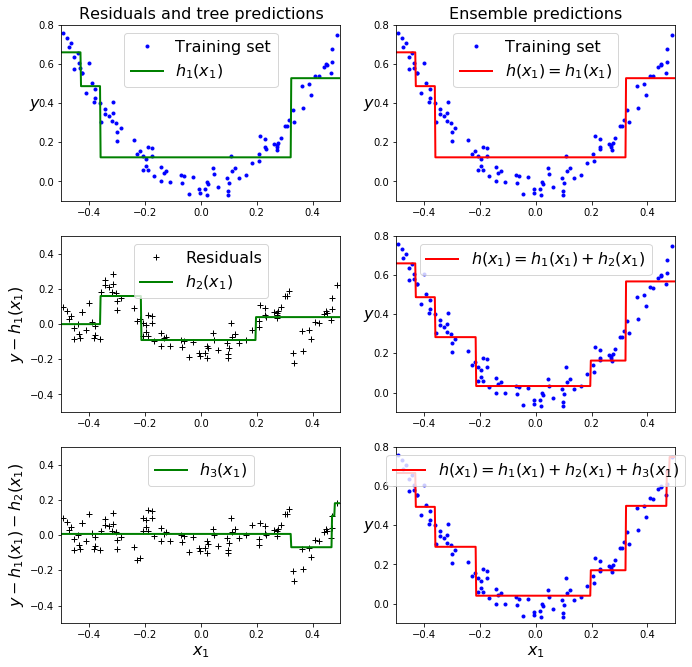

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

트리를 앙상블 함에 따라 점점 예측 성능이 좋아지는 것을 알 수 있다.

사이킷런의 `GradientBoostingRegressor`를 사용하면, GBRT 앙상블을 더욱 쉽게 훈련할 수 있다. 앞서 만든 3개의 트리 앙상블 모델과 같은 모델을 만들어 보면 다음과 같다.

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Shrinkage

Shrinkage는 GBRT의 regularization 방법 중 하나로, learning rate는 줄이고, tree의 수는 늘리는 방법이다. 이렇게 하면, 일반적으로 예측의 성능은 좋아진다.

앞서 구현한 모델과 learning rate는 0.1로 줄이고, tree의 수는 200개로 늘려 shrinkage를 적용한 모델을 새로 학습해 비교해보자.

In [11]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

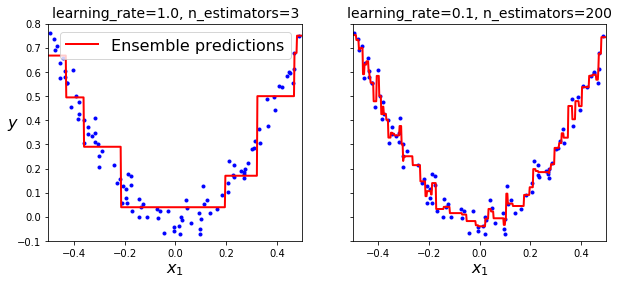

In [12]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

위 결과에서, shrinkage를 적용한 오른쪽의 모델이 왼쪽의 모델보다 조금 나아졌지만, tree의 수를 너무 많이하여 overfitting이 되었는 것을 알 수 있다.

### 최적의 tree 수 찾기

최적의 트리 수를 찾기 위한 방법으로는 early stopping을 사용해볼 수 있다.

`staged_predict()`는 훈련의 각 단계에서 만들어진 모든 GBRT 앙상블 예측기를 순회하는 iterator를 반환한다. 이를 사용하면 최적의 트리 수를 쉽게 찾을 수 있다. 

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=85,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

검증 오차의 그래프와 최적 모델을 그려보면 다음과 같다.

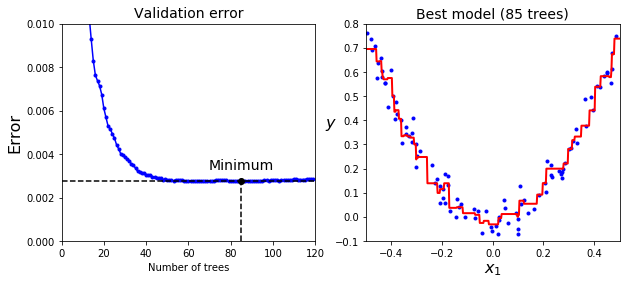

In [14]:
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

`warm_start=True`를 설정하면 기존의 트리를 유지하고 훈련을 추가할 수 있다. 따라서, 다음과 같이 학습 중 성능이 오르지 않을 경우에 학습을 멈추는 방식으로 구현할 수도 있다.

In [15]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        # 5번동안 검증 오차가 향상되지 않으면 훈련 종료
        error_going_up += 1
        if error_going_up == 5:
            break

### Stochastic Gradient Boosting
Stochastic Gradient Boosting은 무작위로 선택된 subsample을 통해 각 tree를 학습하는 방식이다. 이 방법을 사용하면 편향(bias)는 높아지지만 분산(variance)은 낮아지고, 훈련 속도가 증가한다.

### 최적화된 Gradient Boosting 라이브러리
최적화된 Gradient Boosting은 XGBoost 파이썬 라이브러리가 유명하다. XGBoost는 머신러닝 대회에서 많은 우승 후보들이 사용하는 도구 중 하나이며, 다음과 같이 사용할 수 있다. (early stopping과 같은 다양한 기능들도 제공함)

In [20]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error) 

Validation MSE: 0.0036848543862776028
